In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 1.3MB 29.2MB/s 
     |████████████████████████████████| 2.9MB 53.8MB/s 
     |████████████████████████████████| 1.1MB 34.3MB/s 
     |████████████████████████████████| 890kB 49.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=a0724a1408ff50cc56a81e461439904f3c980b513af5e29581b7ceeca259a447
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1f5cb1a3ce1345690ad593cfb508c239d5b7a9ff002382c2d455ade44a225010
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
# from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

In [ ]:
# loading the dataset
train=pd.read_csv("/content/drive/My Drive/3rd Sem/Code v0.2/excel_data/summarydata-bert.csv", encoding= 'unicode_escape')

In [ ]:
train.head()

,News_ID,Newspaper3k,BERT
0,1,"Abu Dhabi [UAE], October 7 (ANI): USA pacer Al...","Abu Dhabi [UAE], October 7 (ANI): USA pacer Al..."
1,2,"Abu Dhabi [UAE], October 6 (ANI): England and ...","Abu Dhabi [UAE], October 6 (ANI): England and ..."
2,3,"Sydney [Australia], October 7 (ANI): Arjun Nai...","Sydney [Australia], October 7 (ANI): Arjun Nai..."
3,4,"Sydney [Australia], October 7 (ANI): Sydney Th...","Sydney [Australia], October 7 (ANI): Sydney Th..."
4,5,Suryakumar hit an unbeaten 79 off 47 balls and...,"Abu Dhabi [UAE], October 6 (ANI): Mumbai India..."


In [ ]:
train.dropna(inplace=True)

In [ ]:
train.isnull().sum()

News_ID        0
Newspaper3k    0
BERT           0
dtype: int64

In [ ]:
#convert each question to a list of string
data = pd.Series(train["BERT"].tolist()).astype(str)

In [ ]:
data.head()

0    Abu Dhabi [UAE], October 7 (ANI): USA pacer Al...
1    Abu Dhabi [UAE], October 6 (ANI): England and ...
2    Sydney [Australia], October 7 (ANI): Arjun Nai...
3    Sydney [Australia], October 7 (ANI): Sydney Th...
4    Abu Dhabi [UAE], October 6 (ANI): Mumbai India...
dtype: object

In [ ]:
data1 = data[:100]

In [ ]:
sentences_list = data

## Text Preprocessing

In [ ]:
nlp = spacy.load('en_core_web_sm')
# stop_list = ['best','different',"won\'t", "couldn\'t", "mustn\'t", "didn\'t", "dtype object"]
# for word in stop_list:
#     spacy.lang.en.stop_words.STOP_WORDS.add(word)
#     nlp.vocab[word].is_stop = True

In [ ]:
def normalize(data):
    """Run all the functions for preprocessing in a pipeline"""
    clean_data = re.sub(re.compile('<.*?>'), '', data)
    cleaned_list = [ unicodedata.normalize('NFKD', word.text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in  nlp(clean_data)]
    cleaned_list = " ".join(cleaned_list)
    cleaned_list = [word.text.rstrip('0123456789').lower() for word in nlp(cleaned_list) if word.pos_  in ['NOUN','PROPN', 'VERB'] and not word.is_digit and not word.is_punct and not word.is_stop ]
    return cleaned_list

In [ ]:
# Preprocess the text data
normalized_data = []
for i, batch in data.groupby(np.arange(len(data)) // 10):
    for batch_data in batch:
        normalized_data.append(normalize(batch_data))

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Data after prerocessing
print(normalized_data[0])
len(normalized_data)

['abu', 'dhabi', 'uae', 'october', 'ani', 'usa', 'pacer', 'ali', 'khan', 'ruled', 'indian', 'premier', 'league', 'ipl', 'injury', 'ali', 'khan', 'signed', 'kkr', 'franchise', 'pacer', 'player', 'usa', 'join', 'ipl', 'franchise', 'cpl', 'title', 'win', 'tkr']


9032

In [ ]:
# function to form sentences from token
sentence = []
sentences = []


def token_2_sentence(normalized_data):
    """Join the tokens in each list with space to form a sentence"""
    for i in normalized_data:
      sentence = " ".join(i)
      sentences.append(sentence)
      sentence = [] 
    return sentences
    
sentences_list = token_2_sentence(normalized_data)

In [ ]:
sentences_list[:10]

['abu dhabi uae october ani usa pacer ali khan ruled indian premier league ipl injury ali khan signed kkr franchise pacer player usa join ipl franchise cpl title win tkr',
 'abu dhabi uae october ani england rajasthan royals rounder ben stokes reckons kartik tyagi run pacer brett lee delivers ball ishant sharma dismissed form quinton de kock defeated batsman pace death overs suryakumar hardik whacked ball park enable run mark',
 'sydney australia october ani arjun nair signed big bash league bbl season sydney thunder tuesday sydney thunder home playing big bash thunder deal means lot',
 'sydney australia october ani sydney thunder completed squad women big bash league season signings england captain heather knight batter tammy beaumont pair members england icc day world cup team galvanize experience australia vice captain rachael haynes pace ace shabnim ismail queensland spearhead sammy jo johnson provide thunder squad crammed emerging stars thunder coach trevor griffin won super leagu

In [ ]:
import csv
with open('./normalized.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow("Normalized")

In [ ]:
for item in sentences_list:
  with open('./normalized.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([item])

In [ ]:
# sentences_list = pd.read_csv("./normalized.csv")
# sentences_list = sentences_list.values.tolist()
# sentences_list[0]

In [ ]:
# sentences_list[0][0]

## Clustering with Embedding

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [00:15<00:00, 15.8MB/s]


In [ ]:
def data_gen(data):
    for sen in data:
      yield sen

In [ ]:
a = data_gen(sentences_list)

In [ ]:
encoding_arr = list()
current = 1
for item in a:
  embeddings = model.encode(item)
  encoding_arr.append(embeddings)
  print("Current:",current)
  current += 1

Streaming output truncated to the last 5000 lines.
Current: 4033
Current: 4034
Current: 4035
Current: 4036
Current: 4037
Current: 4038
Current: 4039
Current: 4040
Current: 4041
Current: 4042
Current: 4043
Current: 4044
Current: 4045
Current: 4046
Current: 4047
Current: 4048
Current: 4049
Current: 4050
Current: 4051
Current: 4052
Current: 4053
Current: 4054
Current: 4055
Current: 4056
Current: 4057
Current: 4058
Current: 4059
Current: 4060
Current: 4061
Current: 4062
Current: 4063
Current: 4064
Current: 4065
Current: 4066
Current: 4067
Current: 4068
Current: 4069
Current: 4070
Current: 4071
Current: 4072
Current: 4073
Current: 4074
Current: 4075
Current: 4076
Current: 4077
Current: 4078
Current: 4079
Current: 4080
Current: 4081
Current: 4082
Current: 4083
Current: 4084
Current: 4085
Current: 4086
Current: 4087
Current: 4088
Current: 4089
Current: 4090
Current: 4091
Current: 4092
Current: 4093
Current: 4094
Current: 4095
Current: 4096
Current: 4097
Current: 4098
Current: 4099
Current: 41

In [ ]:
encoded_arr = np.array(encoding_arr)
encoded_arr_bert = encoded_arr
encoded_arr_bert.shape

(9032, 768)

In [ ]:
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
def tagged_document(normalized_data):
    tagged_corpus = []
    tagged_corpus = [TaggedDocument(words = d, tags=[str(i)]) for i,d in enumerate(normalized_data)]
    return tagged_corpus

In [ ]:
tagged_corpus =  tagged_document(normalized_data)

In [ ]:
tagged_corpus

[TaggedDocument(words=['abu', 'dhabi', 'uae', 'october', 'ani', 'usa', 'pacer', 'ali', 'khan', 'ruled', 'indian', 'premier', 'league', 'ipl', 'injury', 'ali', 'khan', 'signed', 'kkr', 'franchise', 'pacer', 'player', 'usa', 'join', 'ipl', 'franchise', 'cpl', 'title', 'win', 'tkr'], tags=['0']),
 TaggedDocument(words=['abu', 'dhabi', 'uae', 'october', 'ani', 'england', 'rajasthan', 'royals', 'rounder', 'ben', 'stokes', 'reckons', 'kartik', 'tyagi', 'run', 'pacer', 'brett', 'lee', 'delivers', 'ball', 'ishant', 'sharma', 'dismissed', 'form', 'quinton', 'de', 'kock', 'defeated', 'batsman', 'pace', 'death', 'overs', 'suryakumar', 'hardik', 'whacked', 'ball', 'park', 'enable', 'run', 'mark'], tags=['1']),
 TaggedDocument(words=['sydney', 'australia', 'october', 'ani', 'arjun', 'nair', 'signed', 'big', 'bash', 'league', 'bbl', 'season', 'sydney', 'thunder', 'tuesday', 'sydney', 'thunder', 'home', 'playing', 'big', 'bash', 'thunder', 'deal', 'means', 'lot'], tags=['2']),
 TaggedDocument(words=[

In [ ]:

def build_model(tagged_corpus,max_epochs,vec_size, alpha):  
    model = Doc2Vec(size=vec_size, alpha=alpha,min_alpha=0.001, min_count=1,dm =1)
    model.build_vocab(tagged_corpus)

    for epoch in range(max_epochs):
        model.train(tagged_corpus,total_examples=model.corpus_count, epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

        
    model.save("d2v.model")
    print("Model Saved")
    model_name = "d2v.model"
    return model_name


In [ ]:
# from gensim.models.doc2vec import Doc2Vec

def load_model(model_name, data):
    corpus_vector = []
    model= Doc2Vec.load(model_name)
    for doc in data:
        corpus_vector.append(model.infer_vector(doc.split()))
    return corpus_vector

In [ ]:
max_epochs = 100
vec_size = 100
alpha = 0.001
model_name = build_model(tagged_corpus,max_epochs,vec_size, alpha)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


Model Saved


In [ ]:
corpus_vector = load_model("d2v.model",data)  

In [ ]:
corpus_vector = np.array(corpus_vector)

In [ ]:
corpus_vector.shape

(9032, 100)

In [ ]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
corpus_vector_pca = pca.fit_transform(corpus_vector)
print(corpus_vector_pca.shape)

pca = PCA(n_components=2)
encoded_arr_bert_pca = pca.fit_transform(encoded_arr_bert)
print(encoded_arr_bert_pca.shape)

(9032, 2)
(9032, 2)


In [ ]:
#t-SNE 
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
corpus_vector_tsne = tsne.fit_transform(corpus_vector)
print(corpus_vector_tsne.shape)

tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
encoded_arr_bert_tsne = tsne.fit_transform(encoded_arr_bert)
print(encoded_arr_bert_tsne.shape)

(9032, 2)
(9032, 2)


In [ ]:
#KMeans (WITHOUT Dimensionality Reduction)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    # pca = PCA(n_components=2)
    # result = pca.fit_transform(corpus_vector)
    # print(result.shape)

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(corpus_vector)
      Sum_of_squared_distances.append(km.inertia_)
      print(k,":",Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 


In [ ]:
#K-Means on BERT Embedding

10 : 678934.357737165
11 : 671269.917885134
12 : 664449.4732211847
13 : 658180.0726003905
14 : 652480.3868368929
15 : 647256.4101899003
16 : 643409.4440362942
17 : 639764.8780975988
18 : 635518.9174276853
19 : 631896.0613171591
20 : 627961.3379900105
21 : 624851.7760931987
22 : 622047.5419111253
23 : 618561.747314193
24 : 615538.0731981741
25 : 612747.2952620666
26 : 611345.0438034254
27 : 607731.84093197
28 : 606266.5722525228
29 : 603998.066866838


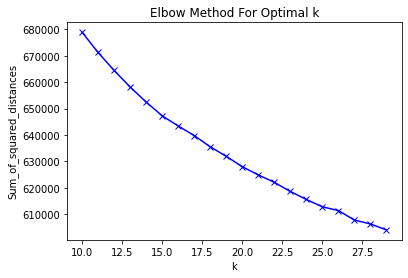

In [ ]:
kmeans(encoded_arr_bert)

In [ ]:
#K-Means on Doc2Vec Embedding

10 : 578.1801830175549
11 : 473.7791707309858
12 : 405.74697022867764
13 : 347.9309583199347
14 : 305.8596349695069
15 : 264.34772804087794
16 : 231.50305087306094
17 : 203.38615047842308
18 : 176.27131669143435
19 : 155.80004330279664
20 : 139.21593019426928
21 : 124.19267834226291
22 : 113.19523780072845
23 : 103.5165667200043
24 : 93.99763896526612
25 : 86.68742704532912
26 : 80.27234145251865
27 : 73.78372332740909
28 : 68.90875076390834
29 : 64.46465027380036


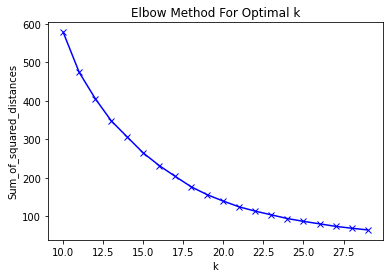

In [ ]:
kmeans(corpus_vector)

In [ ]:
#KMeans (WITH Dimensionality Reduction PCA)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_pca(result):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(result)
      Sum_of_squared_distances.append(km.inertia_)
      print(k,":",Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 
    

10 : 18663.131569219302
11 : 16927.739983946252
12 : 15602.142129586944
13 : 14478.357857129326
14 : 13613.30560033897
15 : 12773.795630966835
16 : 11957.578525018376
17 : 11324.16030450104
18 : 10716.284681572879
19 : 10218.620330481364
20 : 9736.240772859786
21 : 9333.898823917316
22 : 8903.211602158432
23 : 8487.67580336092
24 : 8127.240394289085
25 : 7806.494976071603
26 : 7545.110831746622
27 : 7285.774844190178
28 : 7044.607722760648
29 : 6814.348855992312


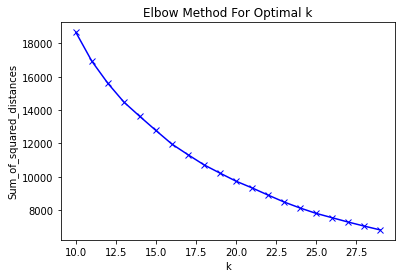

In [ ]:
##K-Means on BERT Embedding + PCA
kmeans_pca(encoded_arr_bert_pca)

10 : 569.8090701311665
11 : 467.4161627071941
12 : 400.9215719910248
13 : 341.5167067297723
14 : 299.20278725232333
15 : 257.13844081147477
16 : 225.46092576452568
17 : 197.9101003153454
18 : 168.70950768063526
19 : 149.42286723988192
20 : 131.88078796434326
21 : 116.69723145854144
22 : 106.5051598335738
23 : 96.83675401240006
24 : 86.8586170706276
25 : 79.53534612236572
26 : 72.76859250065583
27 : 66.8428391817057
28 : 61.57486278307697
29 : 56.976686917769136


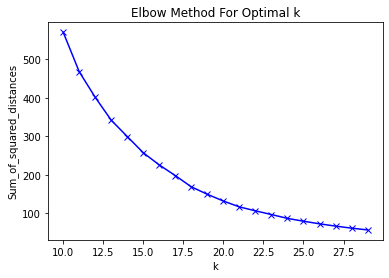

In [ ]:
##K-Means on Doc2Vec Embedding + PCA
kmeans_pca(corpus_vector_pca)

In [ ]:
#KMeans (WITH Dimensionality Reduction T-SNE)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_tsne(result):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
   

    Sum_of_squared_distances = []
    K = range(10,30)
    for k in K:
      km = KMeans(n_clusters=k, max_iter=200, n_init=10)
      km = km.fit(result)
      Sum_of_squared_distances.append(km.inertia_)
      print(k,":",Sum_of_squared_distances[-1])
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    

10 : 779583.3333103703
11 : 706285.015202999
12 : 638611.8071002079
13 : 585632.4333104667
14 : 542154.1778960562
15 : 506330.44656415435
16 : 476825.6325201758
17 : 451676.93344793934
18 : 427334.46493293735
19 : 404758.1823942027
20 : 384374.2826819775
21 : 363105.69380347856
22 : 350395.4257919667
23 : 331397.04073191935
24 : 316626.9587301924
25 : 306537.50362020975
26 : 297687.9655245012
27 : 282051.3344248115
28 : 274851.42856734316
29 : 265712.317972205


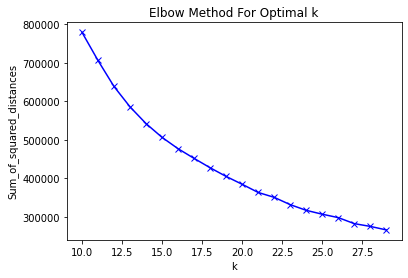

In [ ]:
##K-Means on BERT Embedding + t-SNE
kmeans_tsne(encoded_arr_bert_tsne)

10 : 1263058.656888814
11 : 1120722.071145338
12 : 1007804.7785556671
13 : 894660.4313426887
14 : 808396.1118480843
15 : 698047.2302083657
16 : 608793.6901322852
17 : 548380.4938254217
18 : 498885.3549466238
19 : 443493.17044337635
20 : 397763.2520348772
21 : 365009.9640806653
22 : 337280.50620825414
23 : 316093.7917830592
24 : 289521.8773465089
25 : 272431.67277330445
26 : 256032.12558750235
27 : 239827.14258700315
28 : 226246.8955806042
29 : 214393.43441520914


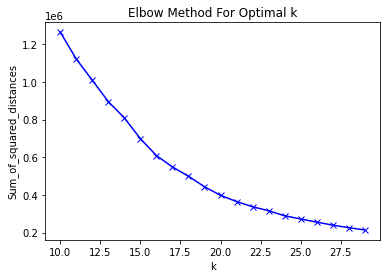

In [ ]:
##K-Means on Doc2Vec Embedding + t-SNE
kmeans_tsne(corpus_vector_tsne)

In [ ]:
def plot_kmeans_pca(true_k, result_pca):
  # pca = PCA(n_components=2)
  # result_pca = pca.fit_transform(corpus_vector)
  # print(result_pca.shape)

  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
  model.fit(result_pca)
  print("SSD:",model.inertia_)
  labels=model.labels_
  print("Labels:",labels)
  y_pred = model.fit_predict(result_pca)
  plt.scatter(result_pca[:,0], result_pca[:,1],c=y_pred, cmap='Paired')
  plt.title("K-Means with k="+str(true_k))
  return labels

SSD: 132.46613718925713
Labels: [15 19  3 ...  6 12  4]


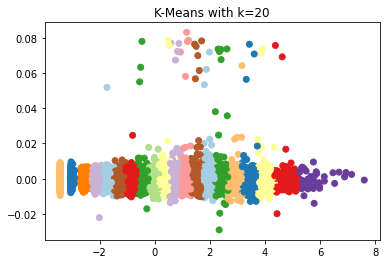

In [ ]:
 labels_kmeans_pca = plot_kmeans_pca(20, corpus_vector_pca)

SSD: 9708.433495675923
Labels: [ 6 10  1 ...  9  9 15]


array([ 6, 10,  1, ...,  9,  9, 15], dtype=int32)

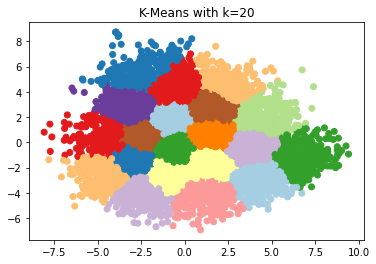

In [ ]:
plot_kmeans_pca(20, encoded_arr_bert_pca)

SSD: 627917.7559826617
Labels: [ 3 11 11 ...  0 13  6]


array([ 3, 11, 11, ...,  0, 13,  6], dtype=int32)

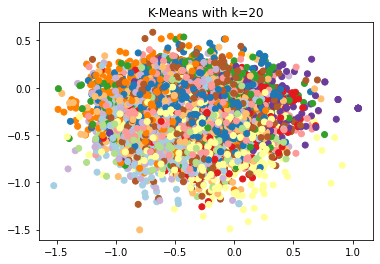

In [ ]:
plot_kmeans_pca(20, encoded_arr_bert)

SSD: 138.8381352914954
Labels: [13 17  3 ...  8 10 10]


array([13, 17,  3, ...,  8, 10, 10], dtype=int32)

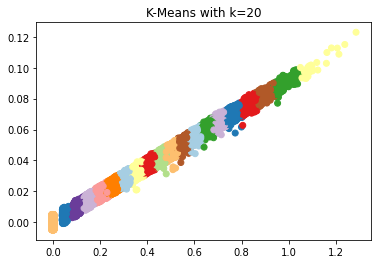

In [ ]:
plot_kmeans_pca(20, corpus_vector)

In [ ]:
def plot_kmeans_tsne(true_k, result_tsne):
  # tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
  # # Use only 400 rows to shorten processing time
  # result_tsne = tsne.fit_transform(corpus_vector)
  # print(result_tsne.shape)

  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
  model.fit(result_tsne)
  print("SSD:",model.inertia_)
  labels=model.labels_
  print(labels)
  y_pred = model.fit_predict(result_tsne)
  plt.scatter(result_tsne[:,0], result_tsne[:,1],c=y_pred, cmap='Paired')
  plt.title("K-Means with k="+str(true_k))

SSD: 397759.4628152194
[ 2  5 10 ... 13 12 12]


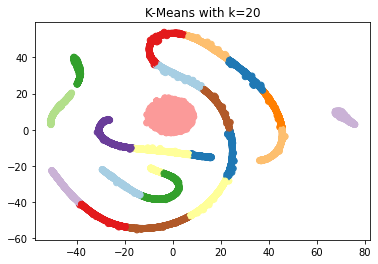

In [ ]:
plot_kmeans_tsne(20, corpus_vector_tsne)

SSD: 384877.6035738
[2 2 2 ... 0 0 7]


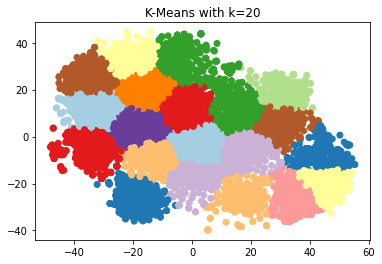

In [ ]:
plot_kmeans_tsne(20, encoded_arr_bert_tsne)

In [ ]:
labels1 = labels_kmeans_pca.tolist()

In [ ]:
total = 0 
for each in range(-1, 21):
  print(each, ":", labels1.count(each))
  total += labels1.count(each)

print(total)

-1 : 0
0 : 472
1 : 475
2 : 436
3 : 1191
4 : 533
5 : 269
6 : 516
7 : 494
8 : 55
9 : 534
10 : 323
11 : 532
12 : 495
13 : 286
14 : 334
15 : 388
16 : 566
17 : 158
18 : 459
19 : 516
20 : 0
9032


In [ ]:
list3 = [i for i, e in enumerate(labels1) if e == 2]

In [ ]:
combined_sent = ""
for each in list3:
  print(sentences_list[each])
  print()
  combined_sent += sentences_list[each]

sydney australia october ani arjun nair signed big bash league bbl season sydney thunder tuesday sydney thunder home playing big bash thunder deal means lot

abu dhabi uae october ani registering win rajasthan royals mumbai indians bowling coach shane bond said jasprit bumrah wanted ball yorkers crunch situations pacer took wickets smith rahul tewatia jofra archer shreyas gopal asked sort planning tackle order royals mumbai indians bowling coach replied lot work scenes opposition

london uk october ani expressing sadness gunnersaurus years midfielder mesut ozil said decided pay wages jerry quy man donned dinosaur suit play arsenal mascot football attending fans football economy

abu dhabi uae october ani playing match winning knock runs rajasthan royals mumbai indians batsman suryakumar yadav said loving responsibility batting order franchise hardik pandya rohit sharma played knocks loving added responsibility order ve told play game express suryakumar yadav told host broadcaster star 

In [ ]:
wordlist = combined_sent.split()
wordfreq = {}
for w in wordlist:
  if w not in wordfreq:
    wordfreq[w] = 0 
  wordfreq[w] += 1
    

In [ ]:
sorted_words = dict(sorted(wordfreq.items(), key=lambda item: item[1],reverse=True))
print(sorted_words)

{'said': 452, 'october': 367, 'ani': 283, 'india': 280, 'oct': 177, 'delhi': 168, 'minister': 157, 'singh': 127, 'thursday': 125, 'coronavirus': 113, 'people': 112, 'government': 106, 'rs': 106, 'wednesday': 100, 'photo': 100, 'film': 98, 'president': 97, 'team': 96, 'police': 93, 'party': 91, 'actor': 89, 'time': 88, 'year': 88, 'announced': 87, 'trump': 85, 'state': 82, 'credit': 81, 'cases': 81, 'world': 80, 'day': 80, 'indian': 78, 'country': 78, 'league': 77, '|': 77, 'friday': 76, 'khan': 73, 'chief': 72, 'tuesday': 71, 'pandemic': 70, 'match': 69, 'covid-': 68, 'monday': 67, 'bjp': 67, 'win': 66, 'took': 65, 'sunday': 65, 'mumbai': 63, 'ipl': 63, 'kings': 63, 'health': 62, 'shared': 61, 'cent': 60, 'according': 59, 'donald': 59, 'season': 57, 'reported': 57, 'years': 56, 'tested': 55, 'family': 55, 'uae': 54, 'leader': 54, 'states': 54, 'news': 54, 'media': 52, 'biden': 52, 'told': 51, 'super': 51, 'end': 51, 'case': 51, 'says': 51, 'home': 50, 'game': 50, 'congress': 49, 'video

In [ ]:
# kmeans_pca(encoded_arr)

In [ ]:
# kmeans(encoded_arr)

In [ ]:
from sklearn.decomposition import PCA

def dbscan(corpus_vector, eps= 0.005, min_samples = 3):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(corpus_vector)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_model = db.fit(result)
    #Forming the clusters

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels1 = dbscan_model.labels_
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
    print(labels1)
    print(len(labels1))
    print(n_clusters_) # number of clusters
    
    clusters1 = {} # a dictionary for different cluster 
    for c, i in enumerate(labels1):
        if i == -1:
            continue
        elif i in clusters1:
            clusters1[i].append( data[c] )
        else:
            clusters1[i] = [data[c]]

    for c in clusters1: # print the different clusters
        # print("Cluster No."+" "+str(c)+" "+str(clusters1[c]))
        # print()
        pass

    return labels1, clusters1

In [ ]:
labels1, clusters1 = dbscan(corpus_vector,0.005,3)

(9032, 2)
[ 0  1  2 ...  5  4 33]
9032
197


In [ ]:
labels1, clusters1 = dbscan(corpus_vector,0.01,3)

(9032, 2)
[0 1 2 ... 1 1 1]
9032
32


In [ ]:
labels1, clusters1 = dbscan(encoded_arr_bert,0.005,3)

(9032, 2)
[-1 -1 -1 ... -1 -1 -1]
9032
15


In [ ]:
labels1, clusters1 = dbscan(encoded_arr_bert,0.02,3)

(9032, 2)
[-1 -1 -1 ... -1 -1 -1]
9032
49


In [ ]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    


(9032, 2)


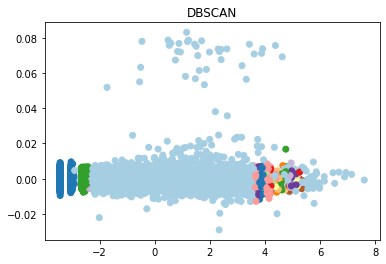

In [ ]:
plot_dbscan(corpus_vector,0.01,3)

(9032, 2)


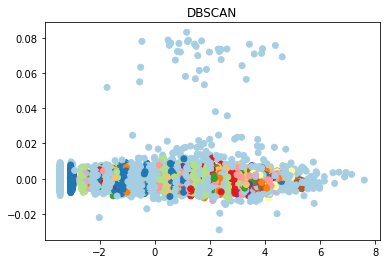

In [ ]:
plot_dbscan(corpus_vector,0.005,3)

(9032, 2)


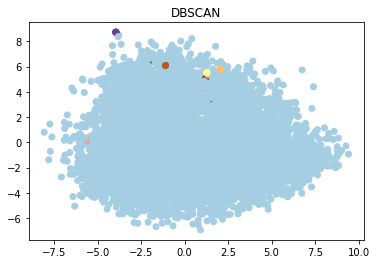

In [ ]:
plot_dbscan(encoded_arr_bert,0.01,3)

(9032, 2)


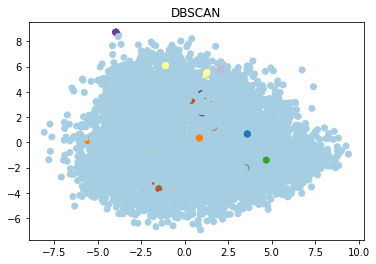

In [ ]:
plot_dbscan(encoded_arr_bert,0.02,3)

In [ ]:
labels1 = labels1.tolist()

In [ ]:
total = 0 
for each in range(-1, 150):
  print(each, ":", labels1.count(each))
  total += labels1.count(each)

print(total)

-1 : 177
0 : 301
1 : 33
2 : 1188
3 : 5252
4 : 420
5 : 472
6 : 48
7 : 371
8 : 281
9 : 5
10 : 73
11 : 44
12 : 96
13 : 3
14 : 6
15 : 36
16 : 9
17 : 10
18 : 14
19 : 5
20 : 12
21 : 3
22 : 4
23 : 15
24 : 5
25 : 8
26 : 23
27 : 5
28 : 4
29 : 11
30 : 18
31 : 7
32 : 7
33 : 7
34 : 7
35 : 5
36 : 12
37 : 3
38 : 4
39 : 4
40 : 8
41 : 4
42 : 3
43 : 3
44 : 3
45 : 3
46 : 0
47 : 0
48 : 0
49 : 0
50 : 0
51 : 0
52 : 0
53 : 0
54 : 0
55 : 0
56 : 0
57 : 0
58 : 0
59 : 0
60 : 0
61 : 0
62 : 0
63 : 0
64 : 0
65 : 0
66 : 0
67 : 0
68 : 0
69 : 0
70 : 0
71 : 0
72 : 0
73 : 0
74 : 0
75 : 0
76 : 0
77 : 0
78 : 0
79 : 0
80 : 0
81 : 0
82 : 0
83 : 0
84 : 0
85 : 0
86 : 0
87 : 0
88 : 0
89 : 0
90 : 0
91 : 0
92 : 0
93 : 0
94 : 0
95 : 0
96 : 0
97 : 0
98 : 0
99 : 0
100 : 0
101 : 0
102 : 0
103 : 0
104 : 0
105 : 0
106 : 0
107 : 0
108 : 0
109 : 0
110 : 0
111 : 0
112 : 0
113 : 0
114 : 0
115 : 0
116 : 0
117 : 0
118 : 0
119 : 0
120 : 0
121 : 0
122 : 0
123 : 0
124 : 0
125 : 0
126 : 0
127 : 0
128 : 0
129 : 0
130 : 0
131 : 0
132 : 0
133 : 0

In [ ]:
[i for i, e in enumerate(labels1) if e == 3]

[3,
 5,
 7,
 10,
 11,
 13,
 14,
 15,
 23,
 24,
 26,
 27,
 29,
 30,
 31,
 32,
 34,
 36,
 37,
 39,
 40,
 41,
 42,
 45,
 48,
 50,
 52,
 54,
 61,
 63,
 67,
 72,
 73,
 74,
 75,
 76,
 78,
 80,
 84,
 85,
 87,
 88,
 92,
 93,
 97,
 99,
 102,
 103,
 104,
 111,
 112,
 114,
 116,
 117,
 119,
 120,
 127,
 128,
 129,
 130,
 132,
 134,
 135,
 138,
 139,
 143,
 144,
 145,
 146,
 149,
 150,
 152,
 153,
 157,
 158,
 161,
 162,
 165,
 167,
 168,
 171,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 184,
 185,
 186,
 189,
 190,
 192,
 194,
 196,
 199,
 204,
 205,
 208,
 209,
 210,
 214,
 217,
 218,
 220,
 221,
 222,
 223,
 225,
 226,
 232,
 235,
 240,
 241,
 242,
 244,
 246,
 247,
 249,
 252,
 254,
 255,
 257,
 259,
 261,
 263,
 264,
 265,
 266,
 269,
 271,
 272,
 273,
 274,
 275,
 277,
 278,
 279,
 282,
 283,
 284,
 286,
 289,
 291,
 292,
 299,
 300,
 301,
 303,
 304,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 315,
 316,
 320,
 323,
 324,
 325,
 326,
 327,
 328,
 331,
 334,
 341,
 342,
 344,
 346,
 350,

In [ ]:
print(sentences_list[20])
print()
print(sentences_list[1468])
print()
print(sentences_list[1523])

abu dhabi uae october ani stumbling defeat hands mumbai indians rajasthan royals wicket keeper batsman jos buttler said team recover losing wickets powerplay managed come order games lost wickets powerplay games win t matches position course powerplay time advantage fielding restrictions players performed happen t cricket buttler said replying ani query press conference

new york usa october ani newsvoir support expansion testing contact tracing india rockefeller foundation announced grants center cellular molecular platforms path.the grants totaling support manufacturing testing materials deployment testing programs mitigating virus spread date foundation dedicated grants supporting frontline organizations africa asia strengthening united states response

new delhi india october ani newsvoir arjun anand author art photographer launched book hamir fallen prince ranthambore webinar called tiffin talks focus hamir tigers ranthambore carries glimpses park


(9032, 2)


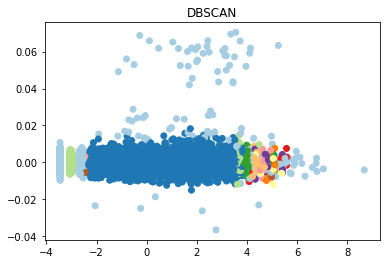

In [ ]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan(corpus_vector,0.01,3)

(9032, 2)


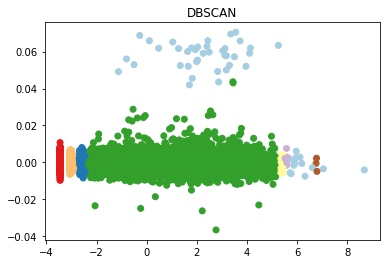

In [ ]:
plot_dbscan(corpus_vector,0.03, 3)

(9032, 2)


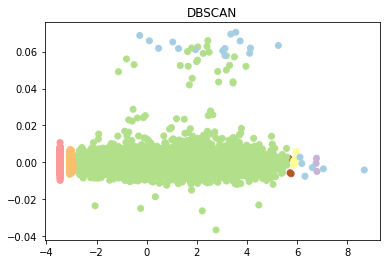

In [ ]:
plot_dbscan(corpus_vector,0.05, 3)